## Param Sodhi and Emmanuel Damas: NBA High Scores and Team Accounts

Emmanuel and I began our study with the goal of analyzing NBA player stats from the 2022-23 and 2023-24 regular seasons to see what drives scoring. Instead of focusing solely on "who scores the most," I'd like to explain the reason why specific players score over the rest.

We constructed our study around three major questions:

1. What player traits are most closely related to points per game?

2. Do more efficient shooters score more?

3. Do guards, forwards, or centers have superior scoring averages?

This notebook describes how we cleaned and integrated both seasons' datasets, as well as how we developed a few additional metrics to help us visualize what it takes to be an exceptional NBA team and player.

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

In [247]:
# We had corrupted characters so we had to use a different encoding since player like Luka Doncic showed up as Luka Don?i?. 
# Had to do some research and found out about cp152.
nba_22_23 = pd.read_csv('/Users/parsodhi/Desktop/nba/2022_2023_NBA_Player_Stats_Regular.csv',sep=';', encoding="cp1252")
nba_23_24 = pd.read_csv('/Users/parsodhi/Desktop/nba/2023_2024_NBA_Player_Stats_Regular.csv',sep=';', encoding="cp1252")

In [248]:
# nba_22_23 = pd.read_csv(
#      '/Users/emmanueldamas/Downloads/2022_2023_NBA_Player_Stats_Regular.csv',sep=';',
#      encoding="ISO-8859-1"
#  )
# nba_23_24 = pd.read_csv(
#      '/Users/emmanueldamas/Downloads/2023_2024_NBA_Player_Stats_Regular.csv',sep=';',
#      encoding="ISO-8859-1"
#  )

## STEP 1
To start off with this section we decide to load player level per game for two NBA Seasons and prepare them for analysis.

So we started off by reading in the CSV files for the 2022–23 and 2023–24 regular seasons. The first thing we thought is that we need to standardize all the columns in our dataset, completely filtering out any anomalies in the naming conventions. Since we did not have any null values we came to the conclusion that this was the first step we should take. We then decided to drop our rank column since it is not helpful.

In [249]:
nba_22_23['season'] = '22-23'
nba_23_24['season'] = '23-24'

In [250]:
nba_22_23.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'season'],
      dtype='object')

In [251]:
nba_23_24.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'season'],
      dtype='object')

In [252]:
nba_22_23.columns = (
    nba_22_23.columns.str.strip().str.lower().str.replace('%', '_pct', regex=False).str.replace(' ', '_')
)

In [253]:
nba_23_24.columns = (
    nba_23_24.columns.str.strip().str.lower().str.replace('%', '_pct', regex=False).str.replace(' ', '_')
)

In [254]:
nba_22_23.columns

Index(['rk', 'player', 'pos', 'age', 'tm', 'g', 'gs', 'mp', 'fg', 'fga',
       'fg_pct', '3p', '3pa', '3p_pct', '2p', '2pa', '2p_pct', 'efg_pct', 'ft',
       'fta', 'ft_pct', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf',
       'pts', 'season'],
      dtype='object')

In [255]:
nba_23_24.columns

Index(['rk', 'player', 'pos', 'age', 'tm', 'g', 'gs', 'mp', 'fg', 'fga',
       'fg_pct', '3p', '3pa', '3p_pct', '2p', '2pa', '2p_pct', 'efg_pct', 'ft',
       'fta', 'ft_pct', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf',
       'pts', 'season'],
      dtype='object')

In [256]:
nba_22_23_withoutrk = nba_22_23.drop(columns=['rk'])
nba_23_24_withoutrk = nba_23_24.drop(columns=['rk'])

In [257]:
nba_22_23_withoutrk.head(10)

,player,pos,age,tm,g,gs,mp,fg,fga,fg_pct,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,season
0,Precious Achiuwa,C,23,TOR,55,12,20.7,3.6,7.3,0.485,...,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2,22-23
1,Steven Adams,C,29,MEM,42,42,27.0,3.7,6.3,0.597,...,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6,22-23
2,Bam Adebayo,C,25,MIA,75,75,34.6,8.0,14.9,0.540,...,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4,22-23
3,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,0.427,...,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9,22-23
4,Santi Aldama,PF,22,MEM,77,20,21.8,3.2,6.8,0.470,...,1.1,3.7,4.8,1.3,0.6,0.6,0.8,1.9,9.0,22-23
5,Nickeil Alexander-Walker,SG,24,TOT,59,3,15.0,2.2,5.0,0.444,...,0.3,1.5,1.7,1.8,0.5,0.4,0.9,1.5,6.2,22-23
6,Nickeil Alexander-Walker,SG,24,UTA,36,3,14.7,2.3,4.7,0.488,...,0.2,1.4,1.6,2.1,0.7,0.4,1.3,1.6,6.3,22-23
7,Nickeil Alexander-Walker,SG,24,MIN,23,0,15.5,2.1,5.4,0.384,...,0.3,1.5,1.8,1.4,0.3,0.3,0.4,1.3,5.9,22-23
8,Grayson Allen,SG,27,MIL,72,70,27.4,3.4,7.7,0.440,...,0.8,2.4,3.3,2.3,0.9,0.2,1.0,1.6,10.4,22-23
9,Jarrett Allen,C,24,CLE,68,68,32.6,5.9,9.2,0.644,...,3.3,6.5,9.8,1.7,0.8,1.2,1.4,2.3,14.3,22-23


In [258]:
nba_23_24_withoutrk.head(10)

,player,pos,age,tm,g,gs,mp,fg,fga,fg_pct,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,season
0,Precious Achiuwa,PF-C,24,TOT,74,18,21.9,3.2,6.3,0.501,...,2.6,4.0,6.6,1.3,0.6,0.9,1.1,1.9,7.6,23-24
1,Precious Achiuwa,C,24,TOR,25,0,17.5,3.1,6.8,0.459,...,2.0,3.4,5.4,1.8,0.6,0.5,1.2,1.6,7.7,23-24
2,Precious Achiuwa,PF,24,NYK,49,18,24.2,3.2,6.1,0.525,...,2.9,4.3,7.2,1.1,0.6,1.1,1.1,2.1,7.6,23-24
3,Bam Adebayo,C,26,MIA,71,71,34.0,7.5,14.3,0.521,...,2.2,8.1,10.4,3.9,1.1,0.9,2.3,2.2,19.3,23-24
4,Ochai Agbaji,SG,23,TOT,78,28,21.0,2.3,5.6,0.411,...,0.9,1.8,2.8,1.1,0.6,0.6,0.8,1.5,5.8,23-24
5,Ochai Agbaji,SG,23,UTA,51,10,19.7,2.1,4.9,0.426,...,0.7,1.8,2.5,0.9,0.5,0.6,0.7,1.3,5.4,23-24
6,Ochai Agbaji,SG,23,TOR,27,18,23.6,2.7,6.8,0.391,...,1.4,1.9,3.3,1.3,0.7,0.6,1.1,1.9,6.7,23-24
7,Santi Aldama,PF,23,MEM,61,35,26.5,4.0,9.3,0.435,...,1.2,4.6,5.8,2.3,0.7,0.9,1.1,1.5,10.7,23-24
8,Nickeil Alexander-Walker,SG,25,MIN,82,20,23.4,2.9,6.6,0.439,...,0.4,1.6,2.0,2.5,0.8,0.5,0.9,1.7,8.0,23-24
9,Grayson Allen,SG,28,PHO,75,74,33.5,4.5,9.1,0.499,...,0.6,3.3,3.9,3.0,0.9,0.6,1.3,2.1,13.5,23-24


## Step 2
One of the most challenging aspects of data cleaning was dealing with players that were on multiple teams during the season. Basketball data, on the other hand, lists each team separately while also include a "TOT" entry that aggregates everything. This means that certain players appear twice or three times in the dataset. This absolutely ruined my correlations at first because the same player was counted many times. To address this, I adjusted the dataset to always prefer real team entries above the TOT aggregate. I gave TOT priority when a player had multiple teams they played for and kept it the same if a person played only on one team

In [259]:
def reduce_to_valid_players(df):
    sorted_players = df.sort_values(by=['player', 'tm'], ascending=[True, True])

    sorted_players['priority'] = (sorted_players.tm != 'TOT').astype(int)
    sorted_players = sorted_players.sort_values(['player', 'priority']).drop_duplicates(subset='player', keep='first')

    return sorted_players.drop(columns='priority').reset_index(drop=True)

In [260]:
nba_22_23_cleaned = reduce_to_valid_players(nba_22_23_withoutrk).reset_index(drop=True)
nba_23_24_cleaned = reduce_to_valid_players(nba_23_24_withoutrk).reset_index(drop=True)

In [261]:
nba_22_23_cleaned.head(10)

,player,pos,age,tm,g,gs,mp,fg,fga,fg_pct,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,season
0,A.J. Green,SG,23,MIL,35,1,9.9,1.5,3.6,0.424,...,0.2,1.1,1.3,0.6,0.2,0.0,0.3,0.9,4.4,22-23
1,A.J. Lawson,SG,22,TOT,15,0,7.2,1.5,2.9,0.500,...,0.4,1.0,1.4,0.1,0.1,0.0,0.2,0.7,3.7,22-23
2,AJ Griffin,SF,19,ATL,72,12,19.5,3.4,7.4,0.465,...,0.5,1.6,2.1,1.0,0.6,0.2,0.6,1.2,8.9,22-23
3,Aaron Gordon,PF,27,DEN,68,68,30.2,6.3,11.2,0.564,...,2.4,4.1,6.6,3.0,0.8,0.8,1.4,1.9,16.3,22-23
4,Aaron Holiday,PG,26,ATL,63,6,13.4,1.5,3.5,0.418,...,0.4,0.8,1.2,1.4,0.6,0.2,0.6,1.3,3.9,22-23
5,Aaron Nesmith,SF,23,IND,73,60,24.9,3.5,8.1,0.427,...,0.8,2.9,3.8,1.3,0.8,0.5,1.0,3.2,10.1,22-23
6,Aaron Wiggins,SG,24,OKC,70,14,18.5,2.7,5.2,0.512,...,1.0,2.0,3.0,1.1,0.6,0.2,0.8,1.6,6.8,22-23
7,Admiral Schofield,PF,25,ORL,37,0,12.2,1.5,3.3,0.451,...,0.6,1.1,1.7,0.8,0.2,0.1,0.4,1.6,4.2,22-23
8,Al Horford,C,36,BOS,63,63,30.5,3.6,7.6,0.476,...,1.2,5.0,6.2,3.0,0.5,1.0,0.6,1.9,9.8,22-23
9,Alec Burks,SG,31,DET,51,8,22.0,3.9,9.0,0.436,...,0.4,2.7,3.1,2.2,0.7,0.2,1.1,1.9,12.8,22-23


In [262]:
nba_23_24_cleaned.head(10)

,player,pos,age,tm,g,gs,mp,fg,fga,fg_pct,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,season
0,A.J. Green,SG,24,MIL,56,0,11.0,1.5,3.5,0.423,...,0.2,1.0,1.1,0.5,0.2,0.1,0.2,0.9,4.5,23-24
1,A.J. Lawson,SG,23,DAL,42,0,7.4,1.3,2.9,0.446,...,0.3,0.9,1.2,0.5,0.2,0.1,0.3,0.5,3.2,23-24
2,AJ Griffin,SF,20,ATL,20,0,8.6,0.9,3.1,0.290,...,0.1,0.8,0.9,0.3,0.1,0.1,0.4,0.3,2.4,23-24
3,Aaron Gordon,PF,28,DEN,73,73,31.5,5.5,9.8,0.556,...,2.4,4.1,6.5,3.5,0.8,0.6,1.4,1.9,13.9,23-24
4,Aaron Holiday,PG,27,HOU,78,1,16.3,2.4,5.3,0.446,...,0.3,1.3,1.6,1.8,0.5,0.1,0.7,1.6,6.6,23-24
5,Aaron Nesmith,SF,24,IND,72,47,27.7,4.4,8.8,0.496,...,0.9,2.9,3.8,1.5,0.9,0.7,0.9,3.3,12.2,23-24
6,Aaron Wiggins,SG,25,OKC,78,4,15.7,2.7,4.8,0.562,...,0.8,1.6,2.4,1.1,0.7,0.2,0.7,1.2,6.9,23-24
7,Adam Flagler,SG,24,OKC,2,0,7.0,0.5,3.5,0.143,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.5,23-24
8,Adama Sanogo,PF,21,CHI,9,0,7.3,1.6,3.0,0.519,...,2.1,1.9,4.0,0.0,0.1,0.0,0.6,0.6,4.0,23-24
9,Admiral Schofield,PF,26,ORL,23,0,3.7,0.4,1.1,0.385,...,0.1,0.6,0.7,0.3,0.0,0.0,0.2,0.4,1.1,23-24


In [263]:
nba_combined = pd.concat([nba_22_23_cleaned, nba_23_24_cleaned], ignore_index=True)

## STEP 3
Checking for duplicates based off of season and player, which as you can see is not an issue since it is 0.

In [264]:
nba_combined.duplicated(subset=['player','season']).sum()

0

In [265]:
nba_combined.head(10)

,player,pos,age,tm,g,gs,mp,fg,fga,fg_pct,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,season
0,A.J. Green,SG,23,MIL,35,1,9.9,1.5,3.6,0.424,...,0.2,1.1,1.3,0.6,0.2,0.0,0.3,0.9,4.4,22-23
1,A.J. Lawson,SG,22,TOT,15,0,7.2,1.5,2.9,0.500,...,0.4,1.0,1.4,0.1,0.1,0.0,0.2,0.7,3.7,22-23
2,AJ Griffin,SF,19,ATL,72,12,19.5,3.4,7.4,0.465,...,0.5,1.6,2.1,1.0,0.6,0.2,0.6,1.2,8.9,22-23
3,Aaron Gordon,PF,27,DEN,68,68,30.2,6.3,11.2,0.564,...,2.4,4.1,6.6,3.0,0.8,0.8,1.4,1.9,16.3,22-23
4,Aaron Holiday,PG,26,ATL,63,6,13.4,1.5,3.5,0.418,...,0.4,0.8,1.2,1.4,0.6,0.2,0.6,1.3,3.9,22-23
5,Aaron Nesmith,SF,23,IND,73,60,24.9,3.5,8.1,0.427,...,0.8,2.9,3.8,1.3,0.8,0.5,1.0,3.2,10.1,22-23
6,Aaron Wiggins,SG,24,OKC,70,14,18.5,2.7,5.2,0.512,...,1.0,2.0,3.0,1.1,0.6,0.2,0.8,1.6,6.8,22-23
7,Admiral Schofield,PF,25,ORL,37,0,12.2,1.5,3.3,0.451,...,0.6,1.1,1.7,0.8,0.2,0.1,0.4,1.6,4.2,22-23
8,Al Horford,C,36,BOS,63,63,30.5,3.6,7.6,0.476,...,1.2,5.0,6.2,3.0,0.5,1.0,0.6,1.9,9.8,22-23
9,Alec Burks,SG,31,DET,51,8,22.0,3.9,9.0,0.436,...,0.4,2.7,3.1,2.2,0.7,0.2,1.1,1.9,12.8,22-23


## STEP 4
We limited the data set to players who played in at least ten games and averaged at least ten minutes per game. This eliminates relatively infrequent players, whose little time on the field would add noise to our scoring analysis.

In [266]:
nba_combined = nba_combined[(nba_combined['g'] >= 10) & (nba_combined['mp'] >= 10)].reset_index(drop=True)

In [267]:
nba_combined.head(10)

,player,pos,age,tm,g,gs,mp,fg,fga,fg_pct,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,season
0,AJ Griffin,SF,19,ATL,72,12,19.5,3.4,7.4,0.465,...,0.5,1.6,2.1,1.0,0.6,0.2,0.6,1.2,8.9,22-23
1,Aaron Gordon,PF,27,DEN,68,68,30.2,6.3,11.2,0.564,...,2.4,4.1,6.6,3.0,0.8,0.8,1.4,1.9,16.3,22-23
2,Aaron Holiday,PG,26,ATL,63,6,13.4,1.5,3.5,0.418,...,0.4,0.8,1.2,1.4,0.6,0.2,0.6,1.3,3.9,22-23
3,Aaron Nesmith,SF,23,IND,73,60,24.9,3.5,8.1,0.427,...,0.8,2.9,3.8,1.3,0.8,0.5,1.0,3.2,10.1,22-23
4,Aaron Wiggins,SG,24,OKC,70,14,18.5,2.7,5.2,0.512,...,1.0,2.0,3.0,1.1,0.6,0.2,0.8,1.6,6.8,22-23
5,Admiral Schofield,PF,25,ORL,37,0,12.2,1.5,3.3,0.451,...,0.6,1.1,1.7,0.8,0.2,0.1,0.4,1.6,4.2,22-23
6,Al Horford,C,36,BOS,63,63,30.5,3.6,7.6,0.476,...,1.2,5.0,6.2,3.0,0.5,1.0,0.6,1.9,9.8,22-23
7,Alec Burks,SG,31,DET,51,8,22.0,3.9,9.0,0.436,...,0.4,2.7,3.1,2.2,0.7,0.2,1.1,1.9,12.8,22-23
8,Aleksej Pokusevski,PF,21,OKC,34,25,20.6,3.2,7.3,0.434,...,1.3,3.4,4.7,1.9,0.6,1.3,1.3,1.7,8.1,22-23
9,Alex Caruso,PG,28,CHI,67,36,23.5,1.9,4.3,0.455,...,0.6,2.3,2.9,2.9,1.5,0.7,1.1,2.4,5.6,22-23


In [268]:
nba_combined['player'].value_counts().sort_values(ascending=False).head(150)

player
Jonas Valan?i?nas        2
Ziaire Williams          2
Amir Coffey              2
Andre Drummond           2
Andrew Nembhard          2
                        ..
Blake Wesley             2
Gordon Hayward           2
Goga Bitadze             2
Trey Murphy III          2
Giannis Antetokounmpo    2
Name: count, Length: 150, dtype: int64

## STEP 5
Now to assess scoring efficiency, we had to create the shooting statistics myself rather than just using the raw shooting columns that they gave. So to be able to get more accurate representation  I calculated field goal, three-point, and free throw percentages based on makes and attempts to ensure consistency and transparency.

Along with this I calculated division by zero issues and the most important stat in all of basketball which id the true shooting percentage. The true shooting percentgae allows us to include efficiency not only from made shots but also including free throws. This offered me an improved understanding of how effectively every player scored, which was critical in addressing my second study question.

In [269]:
df = nba_combined

df['fg_percentage'] = df['fg'] / df['fga']
df['3p_percentage'] = df['3p'] / df['3pa']
df['ft_percentage'] = df['ft'] / df['fta']

df['fg_percentage'] = df['fg_pct'].replace([float('inf')], 0)
df['3p_percentage'] = df['3p_pct'].replace([float('inf')], 0)
df['ft_percentage'] = df['ft_pct'].replace([float('inf')], 0)

In [270]:
df.head(5)

,player,pos,age,tm,g,gs,mp,fg,fga,fg_pct,...,ast,stl,blk,tov,pf,pts,season,fg_percentage,3p_percentage,ft_percentage
0,AJ Griffin,SF,19,ATL,72,12,19.5,3.4,7.4,0.465,...,1.0,0.6,0.2,0.6,1.2,8.9,22-23,0.465,0.390,0.894
1,Aaron Gordon,PF,27,DEN,68,68,30.2,6.3,11.2,0.564,...,3.0,0.8,0.8,1.4,1.9,16.3,22-23,0.564,0.347,0.608
2,Aaron Holiday,PG,26,ATL,63,6,13.4,1.5,3.5,0.418,...,1.4,0.6,0.2,0.6,1.3,3.9,22-23,0.418,0.409,0.844
3,Aaron Nesmith,SF,23,IND,73,60,24.9,3.5,8.1,0.427,...,1.3,0.8,0.5,1.0,3.2,10.1,22-23,0.427,0.366,0.838
4,Aaron Wiggins,SG,24,OKC,70,14,18.5,2.7,5.2,0.512,...,1.1,0.6,0.2,0.8,1.6,6.8,22-23,0.512,0.393,0.831


In [271]:
# Used this source to get the value of how to get the true shooting percentage: https://www.nba.com/stats/help/glossary#tspct
df['ts_percentage'] = df['pts'] / (2 * (df['fga'] + 0.44 * df['fta']))

In [272]:
df['pos_group'] = df['pos'].apply(
    lambda pos: 'Guard' if 'G' in pos else
              'Forward' if 'F' in pos else
              'Center' if 'C' in pos else
              'Other'
)

In [273]:
df.head(5)

,player,pos,age,tm,g,gs,mp,fg,fga,fg_pct,...,blk,tov,pf,pts,season,fg_percentage,3p_percentage,ft_percentage,ts_percentage,pos_group
0,AJ Griffin,SF,19,ATL,72,12,19.5,3.4,7.4,0.465,...,0.2,0.6,1.2,8.9,22-23,0.465,0.390,0.894,0.577322,Forward
1,Aaron Gordon,PF,27,DEN,68,68,30.2,6.3,11.2,0.564,...,0.8,1.4,1.9,16.3,22-23,0.564,0.347,0.608,0.616304,Forward
2,Aaron Holiday,PG,26,ATL,63,6,13.4,1.5,3.5,0.418,...,0.2,0.6,1.3,3.9,22-23,0.418,0.409,0.844,0.524194,Guard
3,Aaron Nesmith,SF,23,IND,73,60,24.9,3.5,8.1,0.427,...,0.5,1.0,3.2,10.1,22-23,0.427,0.366,0.838,0.565130,Forward
4,Aaron Wiggins,SG,24,OKC,70,14,18.5,2.7,5.2,0.512,...,0.2,0.8,1.6,6.8,22-23,0.512,0.393,0.831,0.602837,Guard


### Assumptions ###
In this data cleanup you can see that we made these data assumptions:

1. If a player played on more than 1 team in season, we only account for their TOT.
2. Player must have played 10 games or more and averaged 10 minutes or more per game
3. If player played more than one position, we account for the first position they played
4. We are looking at FG% when determining scoring efficiency (not eFG%). More than FG% we are focusing on TS%.
5. We understand that the Center position will be a little skewed since there are at least two guards and two forwards in each 5 person lineup




In [274]:
# Q1: What player attributes correlate most with high scoring per game?
corr = df[['pts','mp','fga','fg_pct','3pa','3p_pct','fta','ft_pct','ts_percentage','ast','trb','stl','blk','tov']].corr()

corr['pts'].sort_values(ascending=False)

pts              1.000000
fga              0.981685
fta              0.889891
mp               0.873102
tov              0.853550
ast              0.708691
3pa              0.661213
stl              0.570451
trb              0.540804
ft_pct           0.327858
ts_percentage    0.261240
blk              0.246699
3p_pct           0.184791
fg_pct           0.124903
Name: pts, dtype: float64

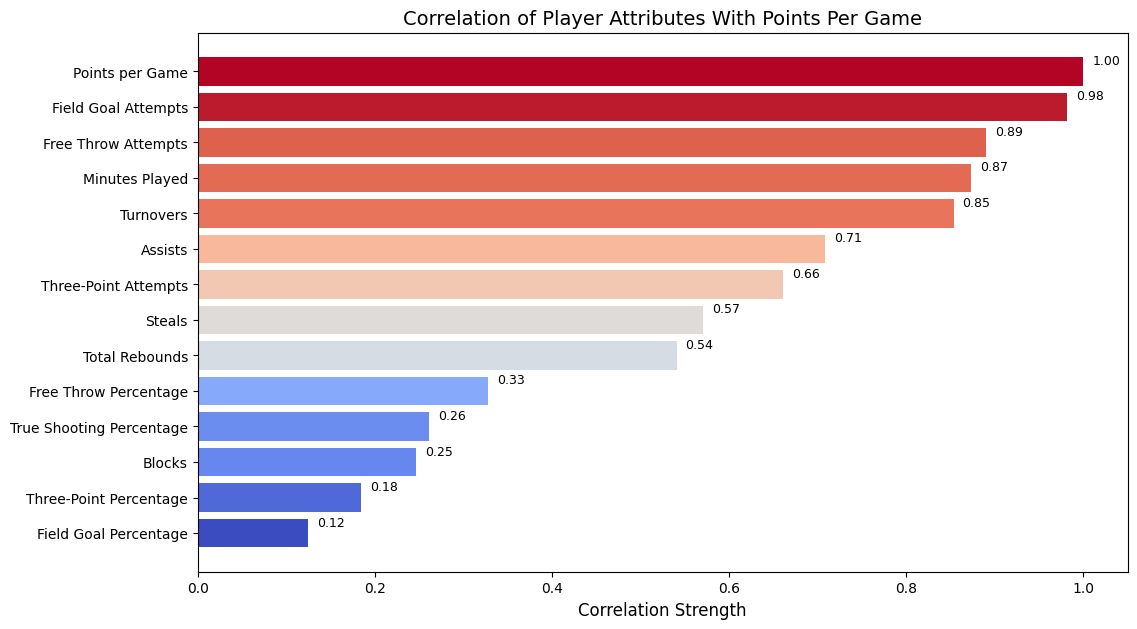

In [275]:
# Create mapping from short stat names to descriptive labels
label_mapping = {
    'pts': 'Points per Game',
    'mp': 'Minutes Played',
    'fga': 'Field Goal Attempts',
    'fg_pct': 'Field Goal Percentage',
    '3pa': 'Three-Point Attempts',
    '3p_pct': 'Three-Point Percentage',
    'fta': 'Free Throw Attempts',
    'ft_pct': 'Free Throw Percentage',
    'ts_percentage': 'True Shooting Percentage',
    'ast': 'Assists',
    'trb': 'Total Rebounds',
    'stl': 'Steals',
    'blk': 'Blocks',
    'tov': 'Turnovers'
}


# Extract sorted correlations with points
pts_corr = corr['pts'].sort_values(ascending=False)

# Replace short labels with full names
pts_corr.index = pts_corr.index.map(label_mapping)

# Normalize values between 0 and 1 for gradient mapping
norm = (pts_corr - pts_corr.min()) / (pts_corr.max() - pts_corr.min())

# Choose a colormap (you can also try "viridis", "coolwarm", "magma")
cmap = plt.cm.coolwarm
colors = cmap(norm)

# Plot
plt.figure(figsize=(12,7))
bars = plt.barh(pts_corr.index, pts_corr.values, color=colors)

plt.title('Correlation of Player Attributes With Points Per Game', fontsize=14)
plt.xlabel('Correlation Strength', fontsize=12)
plt.gca().invert_yaxis()

# Optionally add numeric value labels on bars
for bar, value in zip(bars, pts_corr.values):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/4, f"{value:.2f}", fontsize=9)

plt.show()

### Explaination: ###

The bar chart illustrates the strength of correlation between various player attributes and points per game (PPG). Metrics related to scoring volume—such as field goal attempts, three-point attempts, and free throw attempts—show the strongest positive correlations, indicating that players who take more shots generally score more.

In [276]:
# Q2: Do players who shoot more efficiently score more?
corr_eff = df[['pts','fg_percentage','3p_percentage','ts_percentage']].corr()
corr_eff

,pts,fg_percentage,3p_percentage,ts_percentage
pts,1.000000,0.124903,0.184791,0.261240
fg_percentage,0.124903,1.000000,-0.318230,0.818921
3p_percentage,0.184791,-0.318230,1.000000,0.041562
ts_percentage,0.261240,0.818921,0.041562,1.000000


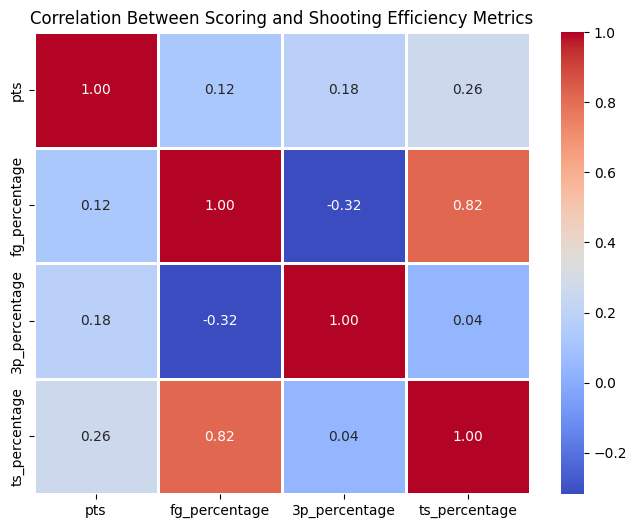

In [277]:
# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_eff, annot=True, cmap='coolwarm', linewidths=1, fmt=".2f")

plt.title("Correlation Between Scoring and Shooting Efficiency Metrics")
plt.show()


## Explanation ##

The heatmap reveals that true shooting percentage (TS%) has the strongest positive correlation with points per game, followed by field goal percentage (FG%) and then three-point percentage (3P%). This suggests that while shooting efficiency contributes to scoring, TS% - which captures overall scoring efficiency including free throws and three-pointers - best explains why some players score more. The moderate correlations also indicate that simply being efficient does not automatically guarantee high scoring; players must also have the opportunity and volume required to produce points.

In [278]:
# Q3: Are guards, forwards, or centers associated with higher scoring averages?
df.groupby('pos_group')['pts'].agg(['count','mean','std'])

,count,mean,std
pos_group,,,
Center,153,9.946405,6.369479
Forward,327,10.307339,6.404907
Guard,356,11.274157,7.014284


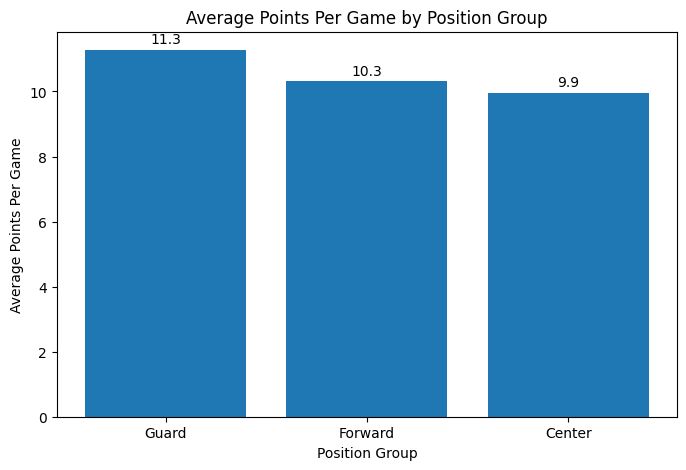

In [279]:
pos_scoring = df.groupby('pos_group')['pts'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
bars = plt.bar(pos_scoring.index, pos_scoring.values)
plt.title('Average Points Per Game by Position Group')
plt.xlabel('Position Group')
plt.ylabel('Average Points Per Game')

# Add labels on top of bars
for i, value in enumerate(pos_scoring.values):
    plt.text(i, value + 0.2, f"{value:.1f}", ha='center', fontsize=10)

plt.show()


## Explaination 

The bar chart provides a clear comparison of average points per game across the primary player position groups (guards, forwards, and centers). From the visualization, one can observe that guards tend to have the highest scoring average, followed closely by forwards, while centers typically score slightly less on average compared to the other two groups.

In [280]:
#sort teams by players with highest pts

def get_players(df):
    #this groups the list by players and points 
    points_per_player = df.groupby('player')['pts'].sum()/2
    #this sorts the values in ascending order and only shows me the top option
    top_players = points_per_player.sort_values(ascending=False).head(1)
    return top_players

In [281]:
#This groups the list of players by team 
grouped = nba_combined.groupby('tm')
#this shows me the highest scorer on each team
top_scorer_by_team = grouped.apply(get_players)
top_scorer_by_team

tm   player                 
ATL  Trae Young                 25.95
BOS  Jayson Tatum               28.50
BRK  Cam Thomas                 16.55
CHI  DeMar DeRozan              24.25
CHO  LaMelo Ball                23.60
CLE  Donovan Mitchell           27.45
DAL  Luka Don?i?                33.15
DEN  Nikola Joki?               25.45
DET  Cade Cunningham            21.30
GSW  Stephen Curry              27.90
HOU  Jalen Green                20.85
IND  Tyrese Haliburton          20.40
LAC  Kawhi Leonard              23.75
LAL  LeBron James               27.30
MEM  Desmond Bane               22.60
MIA  Jimmy Butler               21.85
MIL  Giannis Antetokounmpo      30.75
MIN  Anthony Edwards            25.25
NOP  Zion Williamson            24.45
NYK  Jalen Brunson              26.35
OKC  Shai Gilgeous-Alexander    30.75
ORL  Paolo Banchero             21.30
PHI  Joel Embiid                33.90
PHO  Devin Booker               27.45
POR  Anfernee Simons            21.85
SAC  De'Aaron Fox    

In [282]:
#reset index
top_scorer_df = top_scorer_by_team.reset_index()

# Rename columns
top_scorer_df.columns = ['Tm', 'Player', 'PTS']

# this sort by Team first, then by points descending
top_scorer_df_sorted = top_scorer_df.sort_values(['Tm', 'PTS'], ascending=[True, False])

top_scorer_df_sorted
# this adds a column with the player name + team so I can see both on the bar chart
top_scorer_df['Player_Team_Name'] = top_scorer_df['Player'] + ' (' + top_scorer_df['Tm'] + ')'

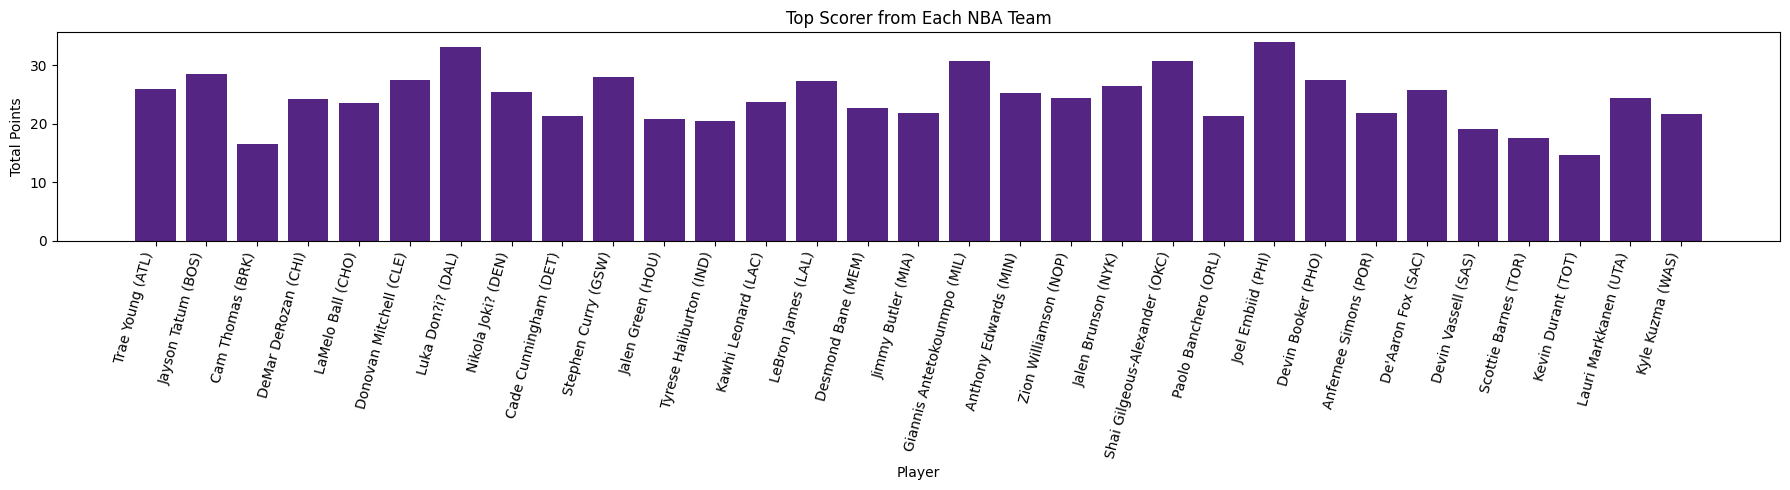

In [283]:
## Plot bar chart for the player with the highest points average on each team

#figure size
plt.figure(figsize=(18,5))
#type of chart and what im looking for in the data frame, in this case its points
plt.bar(top_scorer_df['Player_Team_Name'], top_scorer_df['PTS'], color='#552583')
#chart title and labels
plt.title('Top Scorer from Each NBA Team')
plt.xlabel('Player')
plt.ylabel('Total Points')
#this rotates the name so its easier to read the chart
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

## Explaination
The bar chart highlights the leading scorer from each NBA team and how their average points per game compare across the league. From the visualization, it becomes clear that scoring production varies significantly depending on the team and player role. A few standout players sit well above the rest of the league, indicating teams where the offense is heavily built around a single dominant scorer. These players often serve as primary shot creators and offensive engines, driving both usage rate and scoring output.


In [284]:
# Q4: Do teams with higher scoring lead players win more games?
# Decided to do this again and reset the index
each_team_top_scorer = (
    df.sort_values(['season', 'tm', 'pts'], ascending=False)
      .groupby(['season', 'tm'])
      .first()
      .reset_index()[['season', 'tm', 'player', 'pts']]
)
each_team_top_scorer.head(10)

,season,tm,player,pts
0,22-23,ATL,Trae Young,26.2
1,22-23,BOS,Jayson Tatum,30.1
2,22-23,BRK,Nic Claxton,12.6
3,22-23,CHI,Zach LaVine,24.8
4,22-23,CHO,LaMelo Ball,23.3
5,22-23,CLE,Donovan Mitchell,28.3
6,22-23,DAL,Luka Don?i?,32.4
7,22-23,DEN,Nikola Joki?,24.5
8,22-23,DET,Bojan Bogdanovi?,21.6
9,22-23,GSW,Stephen Curry,29.4


In [285]:
wins = pd.DataFrame([
    {'season': '22-23', 'tm': 'MIL', 'wins': 58},
    {'season': '22-23', 'tm': 'BOS', 'wins': 57},
    {'season': '22-23', 'tm': 'PHI', 'wins': 54},
    {'season': '22-23', 'tm': 'CLE', 'wins': 51},
    {'season': '22-23', 'tm': 'NYK', 'wins': 47},
    {'season': '22-23', 'tm': 'BRK', 'wins': 45},
    {'season': '22-23', 'tm': 'MIA', 'wins': 44},
    {'season': '22-23', 'tm': 'ATL', 'wins': 41},
    {'season': '22-23', 'tm': 'TOR', 'wins': 41},
    {'season': '22-23', 'tm': 'CHI', 'wins': 40},
    {'season': '22-23', 'tm': 'IND', 'wins': 35},
    {'season': '22-23', 'tm': 'WAS', 'wins': 35},
    {'season': '22-23', 'tm': 'ORL', 'wins': 34},
    {'season': '22-23', 'tm': 'CHO', 'wins': 27},
    {'season': '22-23', 'tm': 'DET', 'wins': 17},
    {'season': '22-23', 'tm': 'DEN', 'wins': 53},
    {'season': '22-23', 'tm': 'MEM', 'wins': 51},
    {'season': '22-23', 'tm': 'SAC', 'wins': 48},
    {'season': '22-23', 'tm': 'PHO', 'wins': 45},
    {'season': '22-23', 'tm': 'LAC', 'wins': 44},
    {'season': '22-23', 'tm': 'GSW', 'wins': 44},
    {'season': '22-23', 'tm': 'LAL', 'wins': 43},
    {'season': '22-23', 'tm': 'MIN', 'wins': 42},
    {'season': '22-23', 'tm': 'NOP', 'wins': 42},
    {'season': '22-23', 'tm': 'OKC', 'wins': 40},
    {'season': '22-23', 'tm': 'DAL', 'wins': 38},
    {'season': '22-23', 'tm': 'UTA', 'wins': 37},
    {'season': '22-23', 'tm': 'POR', 'wins': 33},
    {'season': '22-23', 'tm': 'SAS', 'wins': 22},
    {'season': '22-23', 'tm': 'HOU', 'wins': 22},
    
    {'season': '23-24', 'tm': 'BOS', 'wins': 64},
    {'season': '23-24', 'tm': 'OKC', 'wins': 57},
    {'season': '23-24', 'tm': 'DEN', 'wins': 57},
    {'season': '23-24', 'tm': 'NYK', 'wins': 50},
    {'season': '23-24', 'tm': 'MIN', 'wins': 56},
    {'season': '23-24', 'tm': 'MIL', 'wins': 49},
    {'season': '23-24', 'tm': 'PHI', 'wins': 47},
    {'season': '23-24', 'tm': 'CLE', 'wins': 48},
    {'season': '23-24', 'tm': 'NOP', 'wins': 49},
    {'season': '23-24', 'tm': 'PHO', 'wins': 49},
    {'season': '23-24', 'tm': 'IND', 'wins': 47},
    {'season': '23-24', 'tm': 'DAL', 'wins': 50},
    {'season': '23-24', 'tm': 'LAC', 'wins': 51},
    {'season': '23-24', 'tm': 'SAC', 'wins': 46},
    {'season': '23-24', 'tm': 'ORL', 'wins': 47},
    {'season': '23-24', 'tm': 'MIA', 'wins': 46},
    {'season': '23-24', 'tm': 'LAL', 'wins': 47},
    {'season': '23-24', 'tm': 'CHI', 'wins': 39},
    {'season': '23-24', 'tm': 'GSW', 'wins': 46},
    {'season': '23-24', 'tm': 'ATL', 'wins': 36},
    {'season': '23-24', 'tm': 'BRK', 'wins': 30},
    {'season': '23-24', 'tm': 'HOU', 'wins': 41},
    {'season': '23-24', 'tm': 'UTA', 'wins': 31},
    {'season': '23-24', 'tm': 'TOR', 'wins': 25},
    {'season': '23-24', 'tm': 'WAS', 'wins': 15},
    {'season': '23-24', 'tm': 'DET', 'wins': 14},
    {'season': '23-24', 'tm': 'SAS', 'wins': 22},
    {'season': '23-24', 'tm': 'POR', 'wins': 21},
    {'season': '23-24', 'tm': 'CHO', 'wins': 21},
    {'season': '23-24', 'tm': 'MEM', 'wins': 27},
])


In [286]:
each_team = pd.merge(each_team_top_scorer, wins, on=['season','tm'], how='inner')

each_team.head(10)

,season,tm,player,pts,wins
0,22-23,ATL,Trae Young,26.2,41
1,22-23,BOS,Jayson Tatum,30.1,57
2,22-23,BRK,Nic Claxton,12.6,45
3,22-23,CHI,Zach LaVine,24.8,40
4,22-23,CHO,LaMelo Ball,23.3,27
5,22-23,CLE,Donovan Mitchell,28.3,51
6,22-23,DAL,Luka Don?i?,32.4,38
7,22-23,DEN,Nikola Joki?,24.5,53
8,22-23,DET,Bojan Bogdanovi?,21.6,17
9,22-23,GSW,Stephen Curry,29.4,44


In [287]:
each_team['pts'].corr(each_team['wins'])

0.44505400748777246

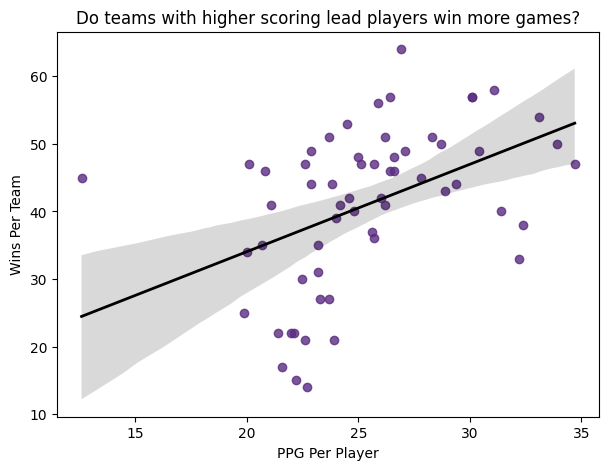

In [288]:
plt.figure(figsize=(7,5))
sns.regplot(x='pts',y='wins',data=each_team,scatter_kws={'color': '#5A2D81'},line_kws={'color': '#000000', 'linewidth': 2})
plt.xlabel("PPG Per Player")
plt.ylabel("Wins Per Team")
plt.title("Do teams with higher scoring lead players win more games?")
plt.show()

## Explaination
The connection between an organization's wins and its top scorer's PPG is at 0.445, showing a moderately positive link. This shows that the team with higher scoring lead players do tend to win more games but the relationship is not a clear indicator. Using the r^2 value we come to the conclusion that only around 20% of the diversity in team wins can be explained by the average score of their best scorer. This indicates that scoring alone is not the best indicator for success. As you can see there are many high level players that play on losing teams and that other factors such as depth and defense may play a more pertinent role. Overall scoring is beneficial but as our data and information show, there are other factors that play a role on performance of a team. 